<img src = "img/jads logo.png" width=500>

<h1 align=center> Introduction to Data Science JBP010 </h1>
<h1 align=center> Data Driven Consulting for Human Resources </h1>

<h3 align=center> October 31th, 2017</h3>

*On a daily basis HR leaders and business managers face many complex challenges that can be overcome by adopting a data-driven approach. In this notebook it is illustrated how human resources could benefit from collecting and analyzing employee data to check for gender equality and workforce diversity and to predict employee turnover.*

---

## Project Description
<div align="justify" style="width:95%;">
A large medicine manufacturer has requested a team of data science students **to identify historical trends for employee attrition and to predict employee turnover in advance** using quantitative methods on a dataset consisting of personal records from all current and past employees. Additionally, the management wonders *what would be effective Human Resource policies given the current workforce and to produce actionable insights in this regard*.
<br/><br/>

The Society of Human Resource Managers [(Kantor, 2017)](https://www.huffingtonpost.com/julie-kantor/high-turnover-costs-way-more-than-you-think_b_9197238.html) estimates that replacing a salaried employee costs 6 to 9 months' salary on average. Given the median wage for workers in the United States was \$44,148 per year in 2016 [(Doyle, 2017)](https://www.thebalance.com/average-salary-information-for-us-workers-2060808), this amounts to roughly \$20K - \$35K per employee. It follows that recruiting fees are significantly higher than the costs associated with measures to attain employees (e.g. promotion, salary increase, additional trainings etc.). In other words, it's a relevant problem because the financial stakes are high.  
<br/>
Since the manufacturer has only recently adopted a data-driven culture, they have very little experience with employee analytics: they used to only produce reports. For that reason the client specifically requested the data scientists to validate the correctness of their internal data and consider more advanced modelling techniques. 

Given this project proposal we first need to establish whether this Data Science project proposal is *hype* or *hope*. Therefore, we answer the following three questions: 

<ol>
    <li> **What main questions are you trying to answer?**</li>
        <ul>
            <li>*How can current and future employee attrition be minimized?*</li> 
            <li>*What actionable insights can you give on the current composition of our workforce?*</li>
        </ul><br>

    <li> **Do you have the data to answer the questions?**</li>
        <br>The manufacturer supplies the following [dataset](https://www.kaggle.com/pavansubhasht/ibm-hr-analytics-attrition-dataset) which consists of 1470 rows and 35 columns. The exploratory analysis, together with the scientific literature, give us a basis to find actionable insights in the data. The predictive analysis shows what features influence attrition, by carefully selecting and tuning a classification model. A similar Kaggle [dataset](https://www.kaggle.com/ludobenistant/hr-analytics/data) will be used to validate the findings in aforementioned dataset.
        Nevertheless, it's very important to note that both datasets are *simulated* which may affect a generalisation to real world data.
<br><br>
        We assume that the drawbacks of any resignation outweigh the potential benefits (e.g. better performance of a new hire). This is a reasonable assumption to make since all employees are evaluated either "Excellent" or "Outstanding" (though in reality is doubtful whether this is really the case). <br><br>

    <li> **If we can answer the question, can we use the answer?**</li>
        <br>Given that the predictive model produces good results, we are then able to predict what factors are more likely to make an employee quit. With this knowledge, the management and  Human Resources department can take action to minimize the number of resignations, both at company level and individual level. For example, adjustments in the working environment, hiring practises, number of trainings per year, work schedules or employees' salary. <br>
        <br>
</ol>
</div>

---

### Prepare the data
<br>
<div align="justify" style="width:95%;">
The dataset includes 6 features which don't add any meaningful value (for a complete overview of all features and their definitions see [Appendix A](#appendix-a)). Either all values are identical (`EmployeeCount`, `StandardHours`, `Over18`) or the attribute definition is unspecified (`HourlyRate`, `DailyRate`, `MonthlyRate`). In [this](https://www.kaggle.com/jamestollefson/modeling-the-business-cost-of-retention) kernel James Tellefson does an excellent job explaining why the latter type of attributes should not be taken into account. He shows that there is not any correlation between various rates of pay (e.g. `DailyRate` and `MonthlyRate`). Therefore, in the comments he concludes that there doesn't seem to be any meaningful relationship between those features at all. That's why all aforementioned features will be excluded from our analysis. Note that after these transformations we end up with a file without any missing values (`NAs`).</div>

In [1]:
%matplotlib inline
import pandas as pd; pd.options.display.float_format = '{:,.3f}'.format
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.figsize'] = (8,6)
import seaborn as sns; sns.set_style("dark")

In [2]:
# Some visualisation functions

def plot_gender_repartition(data, **kwargs):
    caption = kwargs["caption"]; del kwargs["caption"]
    gender_repartition = data.groupby([kwargs["index"], kwargs["columns"]], as_index=False).count().pivot(**kwargs)
    gender_repartition["Total"] = gender_repartition["Male"] + gender_repartition["Female"]
    gender_repartition["Female"] = gender_repartition["Female"] / gender_repartition["Total"] * 100
    gender_repartition["Male"] = gender_repartition["Male"] / gender_repartition["Total"] * 100
    gender_repartition[["Female", "Male"]].plot(kind="barh", stacked=True, legend=False)
    ax = plt.gca()
    ax.axvline(50, color="k", zorder=0)
    format_chart(ax, True)
    label_barh_chart(ax)
    plt.title("{}: Gender Repartition by {}".format(caption, kwargs["index"]), y=-.2)
    plt.legend(bbox_to_anchor=(.7, 1.1), ncol=2)
    plt.subplots_adjust(left=.16, bottom=.2)
    
def format_chart(ax, multiline_labels=False, ticklabel_size=10):
    [spine.set_visible(False) for spine in ax.spines.values()]
    #[tl.set_visible(False) for tl in ax.get_xticklabels()]
    ax.yaxis.set_label_text("")
    [tl.set(fontsize=ticklabel_size) for tl in ax.get_yticklabels()]
    if multiline_labels:
        ylabels = ax.get_yticklabels()
        new_labels = [label.get_text()[::-1].replace(" ", "\n", 1)[::-1] for label in ylabels]
        ax.set_yticklabels(new_labels)
        
def label_barh_chart(ax):
    text_settings = dict(fontsize=9, fontweight='bold', color="w")
    rects = ax.patches
    for i, rect in enumerate(rects):
        width = rect.get_width()
        x_pos = width / 2 if i in range(len(rects) // 2) else 100 - width / 2
        color = "pink" if i in range(len(rects) // 2) else "#2C6388"
        rect.set_facecolor(color)
        label = "{:.1f}%".format(rect.get_width())
        ax.text(x_pos, rect.get_y() + rect.get_height()/2, label, ha='center', va='center', **text_settings)
        
def label_barchart(ax):
    text_settings = dict(fontsize=9, fontweight='bold', color="w")
    rects = ax.patches
    for i, rect in enumerate(rects):
        x_pos = rect.get_x() + rect.get_width() / 2
        label = "{:.1%}".format(rect.get_height())
        ax.text(x_pos, .05, label, ha='center', va='center', **text_settings)

In [3]:
data = pd.read_csv("WA_Fn-UseC_-HR-Employee-Attrition.csv")
columns_to_drop = ['EmployeeCount', 'StandardHours', 'Over18', 'DailyRate', 
                   'HourlyRate', 'MonthlyRate', "EmployeeNumber"]

data = data.drop(columns_to_drop, axis=1)
columns = ["Attrition"] + [col for col in data.columns if col != "Attrition"]
data = data[columns].replace({"Yes": 1, "No": 0})
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 28 columns):
Attrition                   1470 non-null int64
Age                         1470 non-null int64
BusinessTravel              1470 non-null object
Department                  1470 non-null object
DistanceFromHome            1470 non-null int64
Education                   1470 non-null int64
EducationField              1470 non-null object
EnvironmentSatisfaction     1470 non-null int64
Gender                      1470 non-null object
JobInvolvement              1470 non-null int64
JobLevel                    1470 non-null int64
JobRole                     1470 non-null object
JobSatisfaction             1470 non-null int64
MaritalStatus               1470 non-null object
MonthlyIncome               1470 non-null int64
NumCompaniesWorked          1470 non-null int64
OverTime                    1470 non-null int64
PercentSalaryHike           1470 non-null int64
PerformanceRating      

In [4]:
data.groupby("OverTime").mean().loc[:, "Attrition"]

OverTime
0   0.104
1   0.305
Name: Attrition, dtype: float64

First, let's observe what data are available. Without considering the turnover rate the dataset consists of 27 features which can be grouped as follows:<br><br>

<ul>
<li>**Personal**:</li>
<ul><li>Gender, Age, MaritalStatus</li> 
<li>TotalWorkingYears, NumCompaniesWorked</li>
<li>Education, EducationField</li></ul><br>
<li>**Job related**:</li> 
<ul><li>JobLevel, JobRole, Department</li>
<li>MonthlyIncome, StockOptionLevel, PercentSalaryHike</li>
<li>PerformanceRating, TrainingTimesLastYear, JobInvolvement</li></ul><br>
<li>**Career at company**:</li> 
<ul><li>YearsAtCompany, YearsInCurrentRole, YearsSinceLastPromotion, YearsWithCurrManager</li></ul><br>
<li>**Statisfaction**:</li>
<ul><li> RelationshipSatisfaction, EnvironmentSatisfaction, JobSatisfaction</li></ul><br>
<li>**Work intensivity**:</li> 
<ul><li>WorkLifeBalance, BusinessTravel, OverTime, DistanceFromHome</li></ul>
</ul>

---

## Descriptive Analysis
<br>
We will cover 3 themes in this analysis, namely (1) Workforce Composition, (2) Gender Equality and (3) Turnover, by answering the following 10 questions:

* **Workforce composition**
    - How loyal are the employees towards the company?
    - How diverse is the workforce in terms of education? 
    - How does education relate to employee's performance?



* **Gender equality**
    - How are genders distributed across the departments of the company? (horizontal repartition) 
    - How are genders distributed across the hierarchy? (vertical repartition)
    - What differences exist in the compensation of men and women at the same position? 



* **Turnover (Attrition)**
    - What is the relation between employees satisfaction and attrition?
    - What impact has the length of the career on the turnover?
    - How are the different variables correlated?
    - How good are our features for predicting attrition?   

### 1.1 Workforce composition
<h4>How loyal are the employees towards the company? </h4>
<div align="justify"style="width:95%;">
Our first observation is that the average employee is middle-aged (37 years-old). 50% of the employees are between 30 and 43 years old. The average seniority is 7 years but the standard deviation is important (6 years), mostly because of extreme values: the 3rd quartile is 9 years whereas the maximum is 40 years of tenure. In other words, there are some outliers. Figure 1.1 shows that a great share of the workforce stays loyal the company. That is, the majority of their `TotalWorkingYears` has been spent at the current company (i.e. points close to the diagonal).  
</div> 

,Age,YearsAtCompany,TotalWorkingYears
count,"1,470.000","1,470.000","1,470.000"
mean,36.924,7.008,11.280
std,9.135,6.127,7.781
min,18.000,0.000,0.000
25%,30.000,3.000,6.000
50%,36.000,5.000,10.000
75%,43.000,9.000,15.000
max,60.000,40.000,40.000


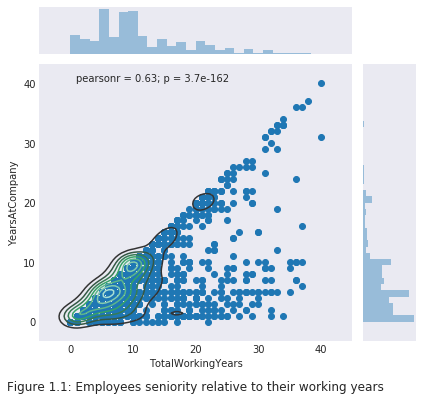

In [5]:
sns.jointplot(x="TotalWorkingYears", y="YearsAtCompany", data=data).plot_joint(sns.kdeplot)
plt.title("Figure 1.1: Employees seniority relative to their working years", y=-.2)
plt.subplots_adjust(bottom=.2)
data[["Age", "YearsAtCompany", "TotalWorkingYears"]].describe()

<div align="justify"style="width:95%;">
In general, employees tend to stay loyal to the company. It is thus the duty of the management to make sure that their workforce is skilled enough to keep performances up for a number of years. One logical driver of employees' performance is their education. The HR-department should make sure that they select candidates with  appropriate educational backgrounds while keeping a diversified workforce. That is why we look into that in the next section.
<br/><br />
<hr>
<h4>How diverse is the workforce in terms of education?</h4>
Our data gives us 5 differents fields of study common in the company (Biology, Medical, Marketing, Technical, Human Resources) and 5 levels of education (No Degree, College, Bachelor, Master, PhD). In the next paragraphs we will analyse how the workforce is structured in terms of education and try to discover insights relative to performance.
<br/><br />
Figure 1.2 shows the distribution of employees according to their field of study (chart on the left) and the level of their education (chart on the right). The most common levels of education are bachelors and masters, followed by college degrees and college dropouts. The fraction of employees with a PhD. is the smallest which is in accordance with the average number of PhD researchers in the US population (<a href="https://www.census.gov/content/dam/Census/library/publications/2016/demo/p20-578.pdf">Ryan & Bauman, 2016</a>).</div>

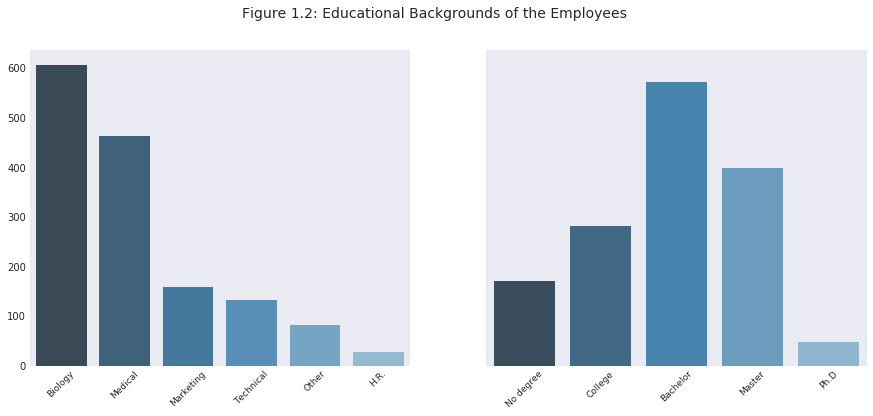

In [6]:
fig = plt.figure(figsize=(15, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, sharey=ax1)

for i, (ax, label) in enumerate(zip([ax1, ax2], ["EducationField", "Education"])):
    vc = data[label].value_counts()
    if i == 1: vc = vc.sort_index()
    sns.barplot(x=vc.index, y=vc.values, palette="Blues_d", ax=ax)
    ax.set_xlabel("")
    [(label.set_fontsize(9), label.set_rotation(45)) for label in ax.get_xticklabels()]

study_fields = ["Biology", "Medical", "Marketing", "Technical", "Other", "H.R."]; ax1.set_xticklabels(study_fields)
diplomas = ["No degree", "College", "Bachelor", "Master", "Ph.D"]; ax2.set_xticklabels(diplomas)
ax2.yaxis.set_visible(False)
plt.suptitle("Figure 1.2: Educational Backgrounds of the Employees", size=14)
plt.subplots_adjust(bottom=.15);

<div align="justify" style="width:95%;">
Figure 1.3 below decomposes the employees by department and field of study. We observe a large sales force and a even bigger pool of researchers. Interestingly enough, we see that a variety of  scientific backgrounds work in the Sales department. It would be interesting to know whether these employees are there from the start or whether they originally started as a researcher and moved to a sales position over the course of their career. Additionally, some educational backgrounds seem to be related to an employee's department. For example, employees with a background in Marketing are only present in the Sales department and similarly, people with a HR-diploma work for the HR-department.</div>

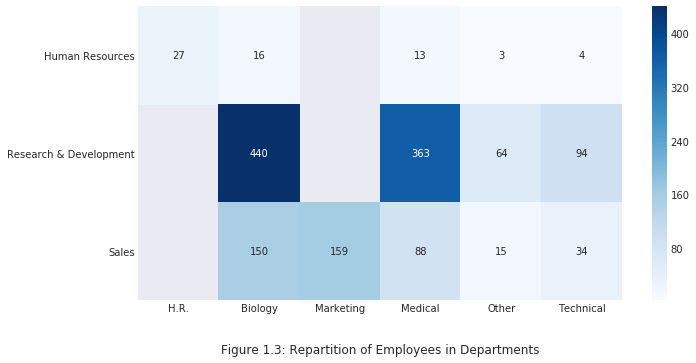

In [7]:
dept_field = (data.pivot_table(data, index="Department", columns="EducationField", aggfunc='size'))
plt.figure(figsize=(12,6))
sns.heatmap(dept_field, annot=True, cmap="Blues", fmt=".0f")
ax = plt.gca()
study_fields = ["H.R.", "Biology", "Marketing", "Medical", "Other", "Technical"]; ax.set_xticklabels(study_fields)
ax.set_xlabel(""); ax.set_ylabel("")
plt.subplots_adjust(left=.2, bottom=.2)
plt.title("Figure 1.3: Repartition of Employees in Departments", y=-.2);

<div align="justify" style="width:95%;">
<hr>
<h4>How does education relate to employee's performance?</h4>
Now, we are interested to observe how well certain types of degrees  perform in different job positions. Since we only have excellent and outstanding performance ratings (3's and 4's), we will look at the proportion of outstanding performers relative to the population with the same combination of education and job role. This allows us to draw conclusions regarding the best matches between job position and field of education.
<br/><br/>
The table below shows the top ten performers. Remarkably, employees with a certain type of background may perform very well in one position while doing badly in another position. For example, managers with a medical diploma do best on average, whereas employees with the same background are performing relatively poorly in a Human Resources position. On the other hand, biologists seem to do quite well as Human Resources employees.
</div>

In [8]:
performance = data.pivot_table(index=['EducationField', 'JobRole'], 
                               columns='PerformanceRating', 
                               values='Attrition', aggfunc='count')

performance['PercentageTopPerformers'] = performance[4] / (performance[3] + performance[4])
performance.sort_values('PercentageTopPerformers', ascending=False).drop([3,4], axis=1).head(10)

,PerformanceRating,PercentageTopPerformers
EducationField,JobRole,
Medical,Manager,0.375
Life Sciences,Human Resources,0.308
Other,Sales Executive,0.308
Technical Degree,Research Scientist,0.231
Other,Healthcare Representative,0.222
Marketing,Manager,0.214
Life Sciences,Manufacturing Director,0.211
Other,Manager,0.200
Life Sciences,Laboratory Technician,0.193


---
### 1.2. Gender equality
<div align="justify" style="width:95%;">
Gender equality was, and still is, the topic of many debates. Some studies suggest that a more diverse workplace increases the performance of the company and the general satisfaction among employees. Nowadays most academics agree that our society should aim for a diverse workplace where male and female are equally represented and equally paid.
<hr>
<h4>How are genders distributed across the departments of the company? (horizontal repartition)</h4>
While we could not demonstrate any differences in terms of wages between men and women, we have evidence that men are much more represented than women in the company. The ratio of men vs. women is 3:2 (meaning that there are 3 men for 2 women). Furthermore, it seems that the representation of women drops after reaching a certain job level. This may be a sign that a glass ceiling exists in this company.<br><br>

Figure 1.5 below shows the repartition of men and women in the different Job Departments of the company. We observe that the department where the representation of men exceeds women's is the highest in Human Resource Department, with more than twice as many men as women. That being said, all departments have a larger proportion of men than women.
</div>

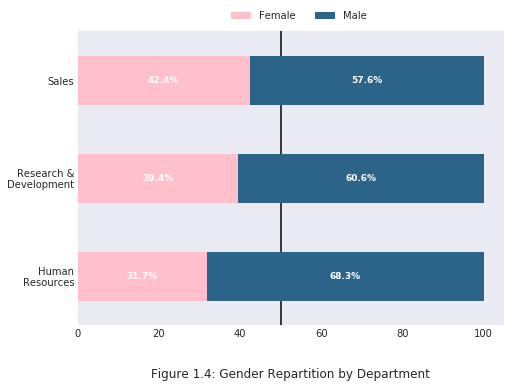

In [9]:
plot_gender_repartition(data, index="Department", columns="Gender", values="Attrition", caption="Figure 1.4")

<hr>
<h4>How are genders distributed across the hierarchy? (vertical repartition)</h4>
<div align="justify" style="width:95%;">
Figure 1.6 shows the repartition of men and women at the different job levels. We see that the proportion of women increases until almost reaching equal representation for Job Level 4. However, as discussed above, the proportion of women decreases rapidly at Level 5. This might be a sign of a glass ceiling keeping women to reach the higher spheres of hierarchy in this company.
</div>

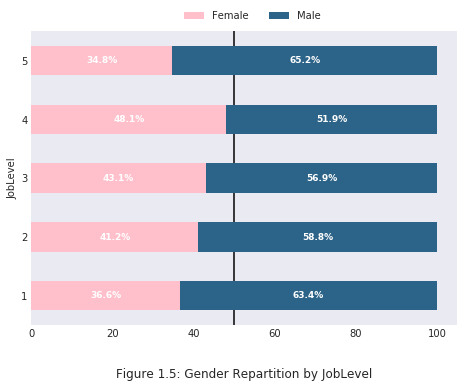

In [10]:
plot_gender_repartition(data, index="JobLevel", columns="Gender", values="Attrition", caption="Figure 1.5")
plt.gca().set_ylabel("JobLevel");

<hr>
<h4>What differences exist in the compensation of men and women at the same position?</h4>
<div align="justify" style="width:95%;">
An unbalanced repartition of men and women does not necessarily mean that there is an income gap between genders. Figure 1.7 illustrates that point: for any job level, we see that the ratio between men and women wages is relatively close to 1, which means that women and men are paid equally in this company.
</div>

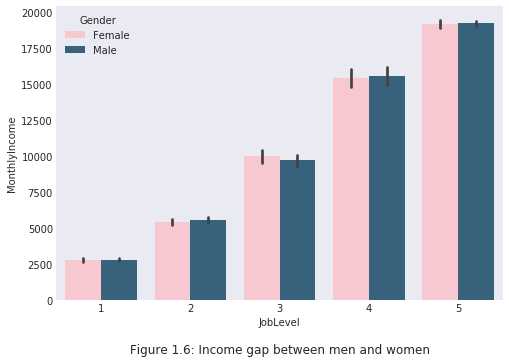

In [11]:
plt.figure()
sns.barplot(x="JobLevel", y="MonthlyIncome", hue="Gender", data=data, ci=99, palette=["pink", "#2C6388"])
plt.title("Figure 1.6: Income gap between men and women", y=-.2)
plt.subplots_adjust(bottom=.2);

---
### 1.3 Turnover

<div align="justify" style="width:95%;">
Now that we have a better grasp of the data, it is time to explore features variance given the turnover. That is, what can we learn from the differences between employees who stayed at the company and those who left. To do this, we will consider the <i>turnover rate</i> in a group of employees, defined as the proportion of employees who quitted in the general population regarding a given feature.

In order to get a more precise idea of which department and which field of study is at stake, we have represented the Figure 1.3, but this time with the turnover rate of the employees. We directly see that technical degrees have a higher rate of attrition, and it is maximal when they are working for the H.R. department. The Sales department sees a large share of its employees leave as well.
</div>

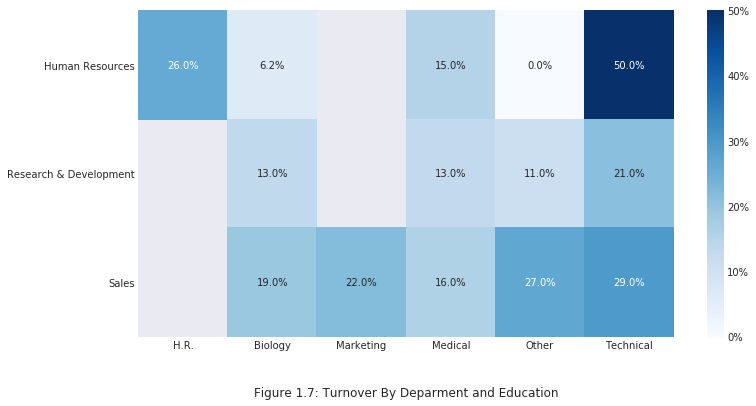

In [12]:
attrition_education = data.pivot_table(index="Department", values="Attrition", columns="EducationField", aggfunc="mean")
plt.figure(figsize=(12,6))
sns.heatmap(attrition_education, annot=True, cmap="Blues")
ax1, ax2 = plt.gcf().get_axes()
ax1.set_xlabel(""); ax1.set_ylabel("")
study_fields = ["H.R.", "Biology", "Marketing", "Medical", "Other", "Technical"]; ax1.set_xticklabels(study_fields)
plt.title("Figure 1.7: Turnover By Deparment and Education", y=-.2)
[el.set_text("{:.1%}".format(float(el.get_text()))) for el in ax1.texts]
ax2.set_yticklabels(["{:.0%}".format(float(tl.get_text())) for tl in ax2.get_yticklabels()]);

<div align="justify" style="width:95%;">
<h4>What is the relation between employees satisfaction and attrition?</h4>
Figure 1.8 shows that low levels of satisfaction are associated with high rates of turnover. The relation between `JobInvolvment` and `Attrition` is even more striking.
</div>

<figure>
<img src="img/Satisfaction.png" style="float:center;" width=800/>
</figure>
<div align="center">Figure 1.8: Satisfaction vs. Turnover Rate</div>

---
<h4>What impact has the length of the career on the turnover?</h4>
<div align="justify" style="width:95%;">
Figure 1.9 shows a high correlation between low seniority and `Attrition`: the less time an employee has spent in the company, the more likely he is to resign. Surprisingly enough, not having been promoted in a while does not seem to play any significant role when choosing to quit or not the company.
</div>

<div align="center">
<img src="img/WorkExperience.png", style="float: left" width=900 />
</div>

<div align="center">Figure 1.9: Satisfaction vs. Turnover Rate</div>

---
<h4>How are the different variables correlated?</h4>
<div align="justify" style="width:95%;">
In the predictive analysis, we will try to predict whether or not an employee is likely to quit given a certain number of explanatory variables. In order to get a better feeling of elements which are relatively strongly related with each other, we will observe the existing correlations in our dataset. But before going any further, it is important to transform our data so that categorical features are considered as such, and not as other numerical variables. We will thus create new (dummy) variables for each category. For example, the feature department will be divided into 3 features corresponding to each individual department.
</div>

In [13]:
data = data.replace({"Male": 1, "Female": 0, "Non-Travel": 0, "Travel_Rarely": 1, "Travel_Frequently": 2})
X, y = pd.get_dummies(data.iloc[:, 1:].copy()), data.iloc[:, 0].copy()

<div align="justify" style="width:95%;">
The Figure 1.10 shows a representation of the correlation matrix of our dataset. Elements that share a strong positive correlation will have a dark red intersection, while strong negative correlation will have a dark blue correlation. Weakly correlated variables have lighter tints of color.<br><br/>
Most of the observed correlations intuitively make sense. For example, employees with a higher job level earn more money, older employees have more work experience, etc. Also note the red area in the upper left red square of the heatmap. These 8 features (`TotalWorkingYears`, `JobLevel`, `MonthlyIncome`, `Age`, `YearsAtCompany`, `YearsInCurrentRole`, `YearsSinceLastPromotion`, `YearswithCurrManager`) are all strongly correlated. These have all something to do with time or experience. Thus a positive relationship between is not surprising. `Attrition` however, does not seem to be correlated with other variables in general, with  the exception of `OverTime` and `MartitalStatus_Single`. <br><br/>
Overal it is good to see that our dataset does not show too much signs of multicollinearity that might otherwise impact the generalisation of the predictive model.
</div>

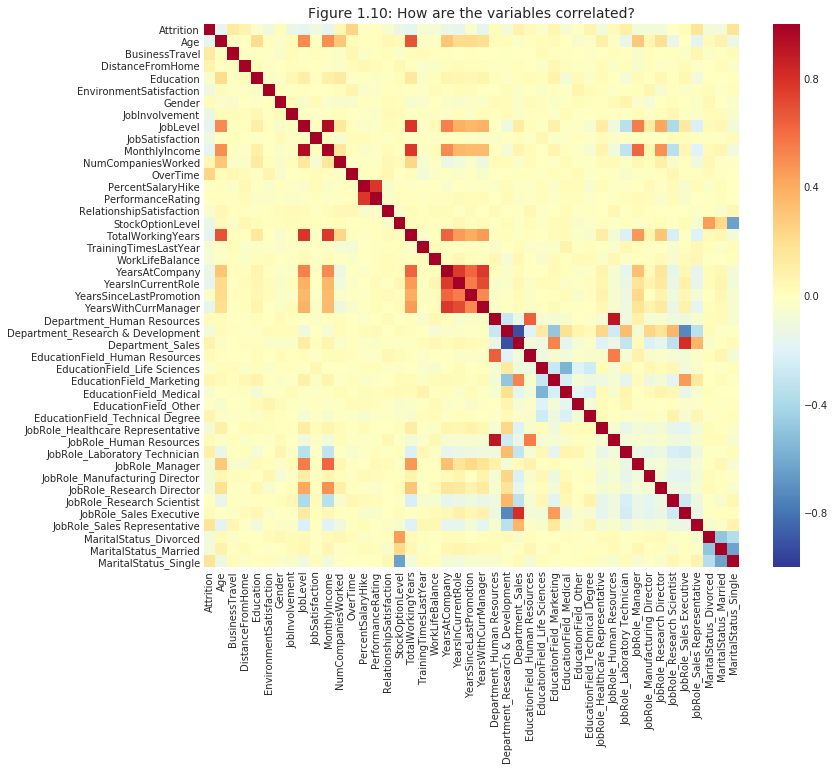

In [14]:
df = X.copy()
df["Attrition"] = y
df = df[["Attrition"] + list(X.columns)]
corr = df.corr()
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(corr, cmap="RdYlBu_r", vmin=-1, vmax=1, ax=ax)
plt.title('Figure 1.10: How are the variables correlated?', size= 14);

---
<h4>How good are our features for predicting attrition?</h4>
<div align="justify" style="width:95%;">
Now we will go one step further in analysing how good our features are to predict attrition. We will look at the predictive power of our variables, by performing an analysis of the variance (ANOVA) to assess the predictive power of our features. ANOVA combined with a Chi-square test answers the question: "Are two joint distributions independent?". The output of the test consists of two values: <br>
<ul>
<li>The **Fisher statistic (F)**, which is the ratio between variations in sample means and variations within the samples. A feature that gets a large F value implies that a much of its is impacted on the target variable `Attrition`.</li> 
<li>The **p-value**, which is the probability to observe such distribution given that two variables are independent. In our case, we want to minimize the p-value.</li></ul>
Generally, in such analysis, we will decide of an arbitrary threshold $\alpha$ that will dictate whether or not a feature passed the test or not. We will choose a confidence level of $1-\alpha = 95 \%$, meaning that we will reject every result above this probability, considering that too little of the variation of the target variable can be explained by the variation of one particular feature.<br><br/>
As can be seen in the correlation matrix above, we see that `OverTime` and `Attrition` are strongly correlated. From all other features, only one did not pass our test. This means that all of the 26 remaining features have less than 5% probability of being totally independent of the dependent variable `Attrition`.
</div>

In [15]:
from sklearn.model_selection import train_test_split
# Train / Test split (size of training set: 75 %)
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [16]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
#X_train["MonthlyIncome"] = scaler.fit_transform(X_train[["MonthlyIncome"]])[0]
#X_test.loc[:, "MonthlyIncome"] = scaler.transform(X_test[["MonthlyIncome"]])
#X_train["MonthlyIncome"]
X_train = X_train.copy(); X_test = X_test.copy()
X_train["MonthlyIncome"] = scaler.fit_transform(X_train[["MonthlyIncome"]])[:,0]
X_test["MonthlyIncome"] = scaler.transform(X_test[["MonthlyIncome"]])[:, 0]

In [17]:
from sklearn.feature_selection import SelectKBest

# Confidence Threshold
alpha = .1

np.random.seed(42)  # To make sure our results are reproducible
anova_filter = SelectKBest()
anova_filter.fit(X_train, y_train)


anova_scores = pd.DataFrame(index=X.columns)

anova_scores["Fisher"] = anova_filter.scores_
anova_scores["p-value"] = anova_filter.pvalues_
anova_scores = anova_scores.sort_values("Fisher", ascending=False)
selected_features = list(anova_scores.loc[anova_scores["p-value"] < 1 - alpha, :].index)
if len(selected_features) == X.shape[1]:
    print("No discarded feature")
X = X[selected_features]
anova_scores.style.apply(lambda f: ["color: red"] * 2 if f["p-value"] > 1-alpha else ["color: black"]*2, axis=1)

No discarded feature


,Fisher,p-value
OverTime,73.8236,2.88785e-17
MaritalStatus_Single,37.2028,1.47212e-09
JobLevel,29.5695,6.644e-08
TotalWorkingYears,27.2486,2.13777e-07
MonthlyIncome,25.9342,4.15362e-07
YearsInCurrentRole,23.7219,1.276e-06
Age,22.9104,1.92872e-06
StockOptionLevel,22.3963,2.50674e-06
YearsWithCurrManager,20.9727,5.18993e-06
EnvironmentSatisfaction,17.5707,2.99032e-05


---
## 2. Predictive Analysis

<div align="justify" style="width:95%;">
The second part of this analysis is dedicated to predict the turnover rate of employees. After having converted categorical data to numerical data with LabelEncoders, we split the dataset into a training and a testing set. The model selection phase is conducted carefully by further splitting the training set into 10 folds and combining them randomly to training and testing sets (i.e. cross-validation).
<br><br/>
Since a large proportion of the target variable is negative, we discarded accuracy as a metric to evaluate the performance of the fitted models. After all, a baseline model (i.e. assume nobody would resign) would correctly classify 80% of our samples, hence reaching a high accuracy without performing well in terms of recall and precision. Instead, we will use a more appriopriate measure the **Receiver Operating Characteristic** (ROC) curve and its corresponding **Area Under the Curve** (AUC) score. This metric reflects True Positives versus False Positive. In our case, a dummy classifier would receive a AUC score of 50% which betters reflects its performance compared to the much higher accuracy score of 80% we obtained previously.<br><br/>
Once we have selected the best model to use, we tune its parameters by performing an exhaustive GridSearch analysis on its hyperparameters. Then we refit the model on the whole training set on the selected model with the optimal parameters and we calculate the final score of the model. For convenience, we have calculated both AUC scores as well as the recall and precision scores to explore what type of errors our classifier makes.</div>

In [18]:
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

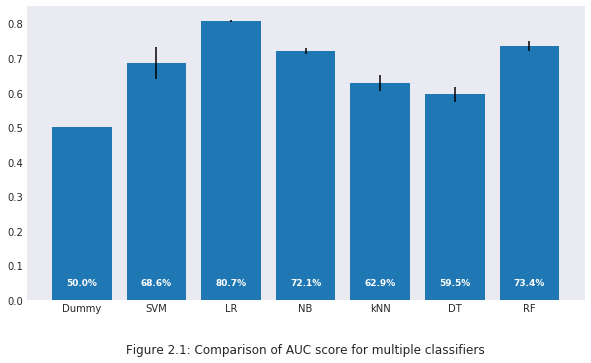

In [19]:
from collections import OrderedDict
from visualisation import label_barchart

scoring = "roc_auc"

models = [
    
    ("Dummy", DummyClassifier(strategy="most_frequent")),
    ("SVM", SVC()), 
    ("LR", LogisticRegression()),
    ("NB", GaussianNB()),
    ("kNN", KNeighborsClassifier()),
    ("DT", DecisionTreeClassifier()), 
    ("RF", RandomForestClassifier())

]

results = OrderedDict()
for name, model in models:
    kfold = KFold(n_splits=3)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results[name] = cv_results
    
results = pd.DataFrame(results)
plt.figure(figsize=(10, 6))
plt.bar(range(results.shape[1]), results.mean(), yerr=results.std())
plt.gca().set_xticklabels([""] + list(results.columns) + [""])
plt.title("Figure 2.1: Comparison of AUC score for multiple classifiers", y=-.2)
plt.subplots_adjust(bottom=.2)
label_barchart(plt.gca())


<div align="justify" style="width:95%;">
The two best base models give us an AUC score of 83.3% and 76.2% for the LogisticRegression and RandomForest respectively. However, we did not perform any tuning of the hyperparameters. This is the next step: we will only select the two top performing models to search among a variety of possible values for the optimal hyperparameters.
</div>

In [1]:
n_features = X_train.shape[1]

classifiers = [
    ("LogisticRegression", LogisticRegression()), 
    ("RandomForest", RandomForestClassifier(n_estimators=50)),
    ("GaussianNB", GaussianNB())
]

all_params = {
    "LogisticRegression": {"penalty": ["l1", "l2"], "C": np.logspace(-3, 3, 7), "class_weight":["balanced", None]}, 
    "RandomForest": {
        "max_features": range(5, n_features, (n_features - 5) // 3), 
        "max_depth": range(3, 6, 2),
        "min_samples_split": range(5, 101, 25)
    },
    "GaussianNB": {"priors": [None, [.161, .839]]}
}
results = pd.DataFrame(index=[item[0] for item in classifiers], 
                       columns=["name", "params", "accuracy", "auc_score_tr", "auc_score_te", 
                                "precision", "recall", "fscore", "support", "TP", "FP", "FN", "TN"])


best_models, scores = [], []
for i, ((name, clf)) in enumerate(classifiers):
    params = all_params[name]
    gs = GridSearchCV(clf, params).fit(X_train, y_train)
    best_models.append(gs.best_estimator_)
    y_pred = gs.predict(X_test)
    precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred)
    auc_score_te = roc_auc_score(y_test, y_pred)
    auc_score_tr = gs.best_score_
    accuracy = (y_pred == y_test).mean()
    params = gs.best_params_
    [[TP, FN], [FP, TN]] = confusion_matrix(y_test, y_pred)
    results.loc[name, :] = (name, params, accuracy, auc_score_tr, auc_score_te, precision, 
                            recall, fscore, support, TP, FP, FN, TN)
    
    scores.append(roc_auc_score(y_test, y_pred))
    gs_results = pd.DataFrame(gs.cv_results_).drop("params", axis=1).sort_values("rank_test_score")
    print("\n{}:\n".format(name))
    print("\tAccuracy: {:.2%}".format((y_pred == y_test).mean()))
    print("\tAUC Score (Train set): {:.2%}".format(gs.best_score_))
    print("\tAUC Score (Test set): {:.2%}\n".format(scores[-1]))
    print(classification_report(y_test, y_pred))
    print(best_models[-1], "\n")
    if i + 1 < len(classifiers): print("#" * 100)
    
#results


NameError: name 'X_train' is not defined

<div align="justify" style="width:95%;">
It turns out the Logistic Regression model gives the best results, scoring an AUC score of 87.1% on the training set and 70.0% on the test set. Also, the logistic model performs better in terms of recall and precision. In fact, it correctly classifies 64% (vs 40%) of all employees who quitted and once it predicts an employee will resign this prediction is correct 44% (vs. 8%) of the time. Further, it seems that the RandomForest may overfit, given the difference between the score on training and testing sets (85% vs 53%).<br><br>

Note that the score that we got after tuning the hyperparameters (70%) is much lower than the previous score from the cross-validation (83%). The testing methodology that was adopted required us to first split the test in 60% training set and 40% testing set. Then, the cross-validation further splitted the training set into 10 folds. The scores have been calculated on a sample of 7.5% of the total volume dataset (i.e. $\sim110$ rows) and 25% for the testing set. We think that this explains the observed difference in performance.<br>
</div>

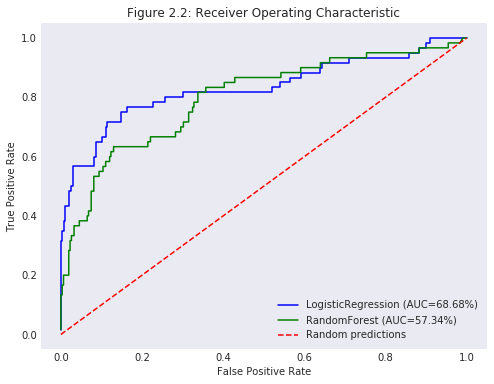

In [21]:
lr_scores = best_models[0].predict_proba(X_test)[:, 1]
rf_scores = best_models[1].predict_proba(X_test)[:, 1]
lr_fpr, lr_tpr, _ = roc_curve(y_test.ravel(), lr_scores.ravel())
rf_fpr, rf_tpr, _ = roc_curve(y_test.ravel(), rf_scores.ravel())
plt.plot(lr_fpr, lr_tpr, 'b', label='LogisticRegression (AUC={:.2%})'.format(scores[0]))
plt.plot(rf_fpr, rf_tpr, 'g', label='RandomForest (AUC={:.2%})'.format(scores[1]))
plt.title('Figure 2.2: Receiver Operating Characteristic')
plt.plot([0,1],[0,1],'r--', label="Random predictions")
plt.legend(loc=4)
plt.ylabel('True Positive Rate'); plt.xlabel('False Positive Rate');

<div align="justify" style="width:95%;">
Figure 2.2 displays the ROC curve for both classifiers, that is the True Positive Rate (TPR) as a function of the False Positive Rate (FPR). We see that LogisticRegression performs always at least as well as the RandomForest. Note that the best possible classifier has a TPR of 1 and a FPR of 0 (meaning that all persons having quitted have been well classified, a no one who has remained has been misclassified).<br><br>

The table below shows the feature importances (coefficients of the logistic model). As expected, `OverTime` is the feature which affects turnover the most (see below). Features related to employee's well being like `JobInvolvement`, `WorkLifeBalance`, `EnvironmentSatisfaction` and `JobSatisfaction` are inversely proportional to the turnover rate. <br>
The same observation can be done for Professional Experience features like `JobLevel`, `YearsInCurrentRole` and `TotalWorkingYears`. One observation in particular is alarming: `PerformanceRating` is positively correlated to `Attrition` which can be a sign of Brain Drain. This phenomena implies that the best performing employees move to other companies because their current employer does not fulfill their expectations. 
</div>

In [22]:
clf = best_models[0]
coef = pd.DataFrame(index=X_train.columns)
coef["Coefficients"] = clf.coef_[0]
coef.sort_values("Coefficients", ascending=False)

,Coefficients
OverTime,1.933
MaritalStatus_Single,0.922
JobRole_Laboratory Technician,0.898
BusinessTravel,0.866
JobRole_Sales Representative,0.860
EducationField_Human Resources,0.761
Gender,0.613
EducationField_Technical Degree,0.584
JobRole_Human Resources,0.584
Department_Sales,0.462


---
## Conclusion
<div align="justify" style="width=95%">


</div>

<div align="justify", style="width:95%;">
Coming back to our starting questions, let's see if we have more elements to answer them:<br><br>
<ul>
    <li>**How can current and future employee attrition be minimized?**</li> 
</ul><br>
First, we observed that employees working overtime are significantly more likely to resign. Our first recommendation is therefore to understand why they are working overtime. For example, if it turns out they have a too high workload, appropriate measures must be taken to reduce the workload.
<br><br>
Second, it seems that once an employee has worked for a certain number of years in the company he will be less likely to resign. That's why it is important to make sure that new hires feel satisfied from the very beginning, especially because at this stage they are most likely to quit. 
<br><br>
Third, the company must be careful not to lose too many employees with a techncial background, especially in the human resources department where the average attrition rate for these employees is 50%. The same holds for laboratory technicians who are far more likely to resign. Therefore it is recommended to further investigate why these employees have a higher attrition rate.
<br><br>
Fourth, employees can be incentivized to stay by offering stock options. After all, the multinomial logistic regression coefficient show that stock options are negatively related to attrition. 
<br><br>
Fifth and last, the company should further look into the existence of a Brain Drain. For example, by surveying high performing employees.
<ul><li>**What actionable insights can you give on the current composition of our workforce?**</li></ul>
The current composition of the workforce might benefit from some adjusments in terms of hiring policies. Although there aren't any significant income differences between men and women, there are remarkably fewer women in the company, especially for job level 1 and 5 positions and the human resources department.
<br><br>
Finally, in terms of what profile to hire, our last recommendation is to carefully match employee's educational background with the job role, since this can improve work performance as we saw before. 

<h4>Discussion and Validation</h4>
As indicated before the <a href="https://www.kaggle.com/ludobenistant/hr-analytics/data">Human Resource Analytics</a> dataset will be compared with ours. In particular, we consider the findings by [Randy Lao](https://www.kaggle.com/randylaosat/predicting-employee-kernelover/notebook). 
<br/><br/>
Randy concludes that both overworked (more than 10hr/day) and underworked employees (less than 6hr/day) generally left the company. The IBM dataset contains the feature `Overtime` of which positive values can be interpreted as overworked employees. Indeed, we also found that employees who work overtime are more likely to resign. In fact, it's our most predictive feature.
<br/><br/>
He also states that employees with either really high or low evaluations should be taken into consideration for high turnover rate. We found a similar result for high performing employees. However, the feature `PerformanceMetric` requires attention since it is doubtful that all employees are really performming *"Excellent"* or *"Outstanding"*.
<br/><br>
Satisfaction was the biggest factor in determining turnover for him. Although, it was not the most significant predictor in our case, we also found a negative relationship between job satisfaction and attrition.
<br/><br/>
Lastly, we also found contradictory results. Where Randy concluded that employees with 4 and 5 years experience at the company have the highest risk of leaving the company, we found that recent hires are most likely to quit.
</div>

---

## Authors

<table align="left">
    <tr>
        <th>Name</th>
        <th>Student-ID</th>
    </tr>
    <tr>
        <td>Roy Klaasse Bos</td>
        <td>2018840</td>
    </tr>
    <tr>
        <td>Quentin Meeus</td>
        <td>20176037</td>
    </tr>
    <tr>
        <td>Jan Seipp</td>
        <td>2018035</td>
    </tr>
</table>

## Appendix A

**Categorical Features**

| Feature | Categories | Definition / Comment | 
| :------- | :----------- | :-------- | 
| Attrition | {Yes, No} | Whether the employee is currently still working for the company. |
| BusinessTravel | {Travel_Rarely, Travel_Frequently, Non-Travel} | How frequency the employee travels for work. |
| Department | {R&D, Sales, HR} | The department the employee works for. An employee can only work for one department. |
| Education | {1=Below College, 2=College, 3=Bachelor, 4=Master, 5=Doctor} | The highest level of education obtained by the employee. |
| EducationField | {Life Sciences, Medical, Marketing, Technical Degree, Other} | The field of study for the most recently finished education program.| 
| EmployeeNumber | {1, 2, .., 2068} | The employee's unique identifier. |
| Gender | {Male, Female} | The employee's gender (mutually exclusive). | 
| JobInvolvement | {1=Low, 2=Medium, 3=High, 4=Very High} | To what extent the employee is involved in his/her work. |
| JobLevel | {1, 2, 3, 4, 5} | *Undefined* - (it is assumed a higher level implies a more senior position). | 
| JobRole | {SalesExecutive, Research Scientist, Laboratory Technician, Manufacturing Director, Healthcare Representative}} | The current position of the employee (mutually exclusive). |
| JobSatisfaction | {1=Low, 2=Medium, 3=High, 4=Very High} | To what extent the employee is satisfied with his/her job. |
| MaritalStatus | {Married, Single, Divorced} | The current relationship status of the employee (mutually exclusive). | 
| Over18 | {Yes} | Whether the employee's age is 18 or higher. Note all employees are older than 18 years old. |
| OverTime | {Yes, No} | *Undefined* - It has been assumed "Yes" refers to an employee whose total working hours is regularly beyond normal working hours. |
| PerformanceRating | {3=Excellent, 4=Outstanding} | At least to say remarkable that all evaluations are either "excellent" or "outstanding" (no "low" or "good" scores).  |
| RelationshipSatisfaction | {1=Low, 2=Medium, 3=High, 4=Very High} | *Undefined* -  (probably the quality of relationships with colleagues and managers) | 
| StandardHours | {80} | *Undefined* - (note that all records in this column are equal to 80). |
| StockOptionLevel | {0, 1} | *Undefined* - (probably whether the job offer includes stock options or not. |
| WorkLifeBalance | {1=Bad, 2=Good, 3=Better, 4=Best} | To what extent the employee is able to combine work and personal life.  |


<br>
**Numerical Features**

| Feature | Mean | Range | Definition / Comment | 
| :------- | :----------- | :----------- |  :----------- |
| Age | 36.9 | 18-60 | The current age of the employee |
| DailyRate | 802 | 102-1500 | *Undefined* | 
| DistanceFromHome | 9.19 | 1-29 | One-way distance from the employee's home to work. Kilometer has been assumed as the measurement unit.
| HourlyRate | 65.9 | 30-100 | *Undefined* |
| MonthlyIncome | 6.50K | 1.01K - 20.0K | The monthly earnings of the employee. Since the data originates from IBM the American US dollar has been assumed as the used currency. |
| MonthlyRate | 1.4K | 2.09K - 27K | *Undefined* |
| NumCompanies | 2.69 | 0-9 | The number of companies worked for previously (excluding the current company). |
| PercentSalaryHike | 15.2 | 11-25 | *Undefined* - (definition is unclear, especially since employees who have never been promoted (JobLevel=1) still have a salary hike of  11% or higher). |
| TotalWorkingYears | 11.3 | 0-40 | The total number of working years at the current company plus any previous experiences. | 
| TrainingTimesLastYear | 2.8 | 0-6 | The number of trainings the employee participated in last year. |
| YearsAtCompany | 7.01 | 0-40 | The total number of working years at the current company. |
| YearsInCurrentRole | 4.23 | 0-18 | The number of years the employee has worked in the current position. |
| YearsSinceLastPromotion | 2.19 | 0-15 | The number of years since the last promotion. Note that an employee can be promoted without changing postions. |
| YearsWithCurrManager | 4.12 | 0-17 | The number of years the employee has worked for his/her current manager. |